# SLO Police Logs: Tidy

In [1]:
import pandas as pd

In this exercise, you will parse police log data from the [City of San Luis Obispo](http://www.slocity.org) in California. Each day, the police department posts a text log file of all the incidents for that day:

http://www.slocity.org/government/department-directory/police-department/police-log

A dataset of these log files is available in the data directory. You will parse these files into a tidy `DataFrame`.

## Parse a single incident entry

First, you will write a series of functions that parse a single incident entry. You may find the following `MARKER` text to be helpful:

In [2]:
MARKER = '====='

A single text file consists of a series of incident entries, where each entry looks something like this:

In [3]:
entry = """===============================================================================
160728012 07/28/16 Received:07:11 Dispatched:07:13 Arrived:      Cleared:07:15
===============================================================================
Type: Alarm Audible                                           Location:PN13
As Observed:


Addr: 12318 LOS OSOS VALLEY; ENTERPRISE RENT A   Clearance Code:Call Cancelled

Responsible Officer: Benson, G
Units: 4245  ,4231
 Des: incid#=160728012 Completed call disp:CAN clr:CAN call=18l
CALL COMMENTS: FRONT DOOR, REAR MOTION
"""

It is important to note that the exact format of the entries varies widely. To get a better sense of what you are up against, you should `cat` some of the data files before starting this exercise.

First, write a function that takes the header line of an entry (the line between the two `MARKER` lines), and returns a Python `dict` for the values in the header. See the tests below for the exact fields you should extract. You will likely have to deal with the possibility of missing values.

In [4]:
def parse_header(text):
    """Parse the incident header line as text and return a python dict."""
    split = [x for x in text.split(' ') if x != '']
    header_info = {'id': split[0],
                   'date': split[1],
                   'received': split[2][len('Received:'):],
                   'dispatched': split[3][len('Dispatched:'):],
                   'arrived': split[4][len('Arrived:'):],
                   'cleared': split[5][len('Cleared:'):]}
    return header_info

In [5]:
h = parse_header(entry.splitlines()[1])
assert h == \
    {'arrived': '',
     'cleared': '07:15',
     'date': '07/28/16',
     'dispatched': '07:13',
     'id': '160728012',
     'received': '07:11'}

Not write a function that takes takes the line of text containing the `Type` and `Location` and return a `dict` of those fields. Again, you will have to deal with the possibility of missing values.

In [6]:
def parse_type_location(text):
    """Parse the type/location line of text into a dict."""
    split = [x.strip().lower() for x in text.split('Type:')[1].split('Location:')]
    type_info = { 'location': split[1],
                  'type': split[0]}
    return type_info

In [7]:
type_location = parse_type_location(entry.splitlines()[3])
assert type_location=={'location': 'pn13', 'type': 'alarm audible'}
type_location = parse_type_location('Type: this that Location:')
assert type_location == {'location': '', 'type': 'this that'}

Write a function to parse the line with `Units` into a `dict`:

In [8]:
def parse_units(text):
    """Parse the line containing `Units:` into a dict."""
    split = [x.strip() for x in text[len('Units: '):].split(',') if x != '']
    unit_info = {'units': split}
    return unit_info

In [9]:
units = parse_units(entry.splitlines()[-3])
assert units=={'units': ['4245', '4231']}
units = parse_units('Units:')
assert units=={'units': []}

Write a function that parses an entire incident entry. Handle the following lines of the entry:

* The header line
* The type/location line
* The units line

Your function should call the above functions that parse each of these lines; other lines should be ignored.

In [10]:
def parse_incident(text):

    lines = [line for line in text.splitlines() if line != '']
    d = {}
    for line in lines:
        if 'Arrived:' in line:
             d.update(parse_header(line))
        elif 'Location:' in line:
             d.update(parse_type_location(line))
        elif 'Units:' in line:
             d.update(parse_units(line))
    return d

In [11]:
incident = parse_incident(entry)
assert incident == \
    {'arrived': '',
     'cleared': '07:15',
     'date': '07/28/16',
     'dispatched': '07:13',
     'id': '160728012',
     'location': 'pn13',
     'received': '07:11',
     'type': 'alarm audible',
     'units': ['4245', '4231']}

## Read all files and parse the entries

In [12]:
import glob
files = glob.glob('/data/slo_police_logs_2017-02/*2016-08*.txt')
files

['/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-05-1901.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-03-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-22-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-15-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-29-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-19-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-18-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-10-2052.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-02-1200.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-31-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-10-2050.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-23-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-24-1700.txt',
 '/data/slo_police_logs_2017-02/SLOPolice_TDGAcq2016-08-11-1920.txt',
 '/data/slo_police_l

Write a generator function that takes a list of filenames and yields the lines of the files:

In [13]:
def files_to_lines(files):
    """Take a list of files and yield their lines."""
    for file_name in files:
        lines = []
        with open(file_name) as f:
            lines = f.readlines()
        for line in lines:
            yield line.strip()


In [14]:
import hashlib, types
lines_hash = hashlib.md5()
for line in files_to_lines(files):
    lines_hash.update(line.encode())
assert lines_hash.hexdigest()=='5aec19b16d5457832d5ccc4ba02930a2'
assert type(files_to_lines(files)) == types.GeneratorType

Write a generator function that consumes an iterator of lines from the incident files, and yields a sequence of text based incident entries. Each entry that is yielded should be a single string, with embedded newlines.

In [15]:
def lines_to_indicents(lines):
    """Consume an iterator of lines, yield text blocks of for each incident."""
    count = 0
    adding = False
    entry = ''
    next_line = next(lines, None)
    while(next_line != None):
        if not adding and MARKER in next_line:
            adding = True
        if adding:
            entry += next_line + '\n'
        next_line = next(lines, None)
        if next_line == None:
            #yield entry
            break
        if adding and '-----' in next_line:
            yield entry
            entry = ''
            adding = False
            count = 0

        if adding and MARKER in next_line:
            if count == 0:
                count += 1
            elif count == 1:
                yield entry
                entry = ''
                count = 0

Using the functions you have defined above, iterate through the filenames in the variable `files`, parse all the incident entries into Python `dict` objects and return a list of those objects named `incidents`:

In [16]:
incidents = []
index = 0;
for entry in lines_to_indicents(files_to_lines(files)):
    incidents.append(parse_incident(entry))
    index+=1
del incidents[2616]
#Told to drop the last incident since the solution does not handle it correctly

In [17]:
incidents[200]

{'arrived': '11:01',
 'cleared': '11:25',
 'date': '08/19/16',
 'dispatched': '10:58',
 'id': '160819036',
 'location': 'pn5',
 'received': '10:57',
 'type': 'disorderly',
 'units': ['4268', '4231']}

In [18]:
assert len(incidents) == 2616
assert type(incidents) == list
assert incidents[100] == \
    {'arrived': '06:33',
     'cleared': '06:34',
     'date': '08/05/16',
     'dispatched': '06:18',
     'id': '160805013',
     'location': 'pn11',
     'received': '06:16',
     'type': 'alarm audible',
     'units': ['4266', '4266', '4265']}
assert incidents[200] == \
    {'arrived': '11:01',
     'cleared': '11:25',
     'date': '08/19/16',
     'dispatched': '10:58',
     'id': '160819036',
     'location': 'pn5',
     'received': '10:57',
     'type': 'disorderly',
     'units': ['4268', '4231']}

## Create the incident DataFrame

Convert the `incidents` list-of-dicts to a Pandas `DataFrame` named `incidents_df` with a format given by the tests below.

In [19]:
incidents_df = pd.DataFrame(incidents).drop(columns = ['units'])

In [20]:
incidents_df.head()

,arrived,cleared,date,dispatched,id,location,received,type
0,07:37,07:48,08/04/16,07:26,160804007,pn7,07:23,traffic hazard
1,07:52,08:01,08/04/16,07:42,160804008,pn5,07:40,loitering
2,,,08/04/16,,160804009,pn8,08:02,muni code viol
3,,08:07,08/04/16,08:07,160804010,pn1,08:03,aband vehicle
4,08:22,08:28,08/04/16,,160804011,pn5,08:14,mc-panhandling


In [21]:
assert list(incidents_df.location.unique()) == \
    ['pn7', 'pn5', 'pn8', 'pn1', 'pn13', 'pn10', 'pn2', 'pn9', 'pn12',
       'pn11', 'pn6', 'pn3', 'lz0', 'pn4', '']
assert len(incidents_df['type'].unique()) == 81
assert list(incidents_df.columns) == \
    ['arrived', 'cleared', 'date', 'dispatched', 'id', 'location',
     'received', 'type']

Create a second `DataFrame`, named `units_df` with two columns:

* The `id` of the incident
* The `unit` that handled the call.

If there are multiple units for an id, insert multiple rows for that id (one for each unit). This is needed to make this `DataFrame` tidy.

In [22]:
units_df = pd.DataFrame(incidents, columns = ['id', 'units'])
units_df.columns = ['id', 'unit']

In [23]:
units_df = pd.DataFrame(columns = ['id', 'unit'])
count = 0
for entry in incidents:
    for unit in entry['units']:
        if unit != '':
            units_df.loc[count] = list([entry['id'], unit])
            count += 1

In [24]:
units_df.head()

,id,unit
0,160804007,42K4
1,160804007,4202
2,160804008,4226
3,160804008,4218
4,160804009,SET


In [25]:
assert len(units_df) == 4617
assert list(units_df.columns) == ['id', 'unit']

## Visualize

In [26]:
import altair as alt
alt.enable_mime_rendering()

Create a single visualization using Altair that explores this dataset visually and begins to provide a high level overview of the information in the dataset.

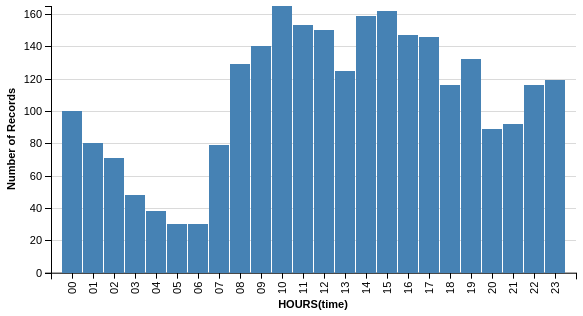

In [27]:
incidents_df['time'] = pd.to_datetime(incidents_df['received'])
alt.Chart(incidents_df).mark_bar().encode(
    alt.X('time:T', timeUnit='hours'),
    alt.Y('count(*)'),
)

The received reports are extremely low at 5 and 6 AM and highest in the afternoon.